<a href="https://colab.research.google.com/github/JonRivera/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [153]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [154]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [155]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [169]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [157]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [158]:
print(df.describe(exclude='number').shape)
df.describe(exclude='number')


(4, 10)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,23040,23040,23040,23039,23039,23040,5201,22987,23040,23040
unique,5,11,44,10,146,22691,1724,3652,147,120
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,D4,100 JEROME STREET,4,0,D4,01/24/2019
freq,7494,19117,5061,11071,3408,6,99,7500,3408,480


In [159]:
df.describe()

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,23040.000000,23040.000000,0.0,23039.000000,23039.000000,23039.000000,23039.000000,2.303900e+04,23005.000000,23040.000000,2.304000e+04
mean,4459.116493,353.948481,NaN,10791.186987,1.827423,0.286514,2.320891,3.508555e+03,1819.671724,1.624479,1.328133e+06
std,3713.269887,628.025255,NaN,1103.414210,10.090432,5.778224,12.070554,2.218610e+04,488.376571,0.803898,1.025394e+07
min,1.000000,1.000000,NaN,0.000000,0.000000,-148.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00
25%,1341.000000,22.000000,NaN,10306.000000,0.000000,0.000000,1.000000,4.940000e+02,1920.000000,1.000000,0.000000e+00
50%,3546.000000,49.000000,NaN,11211.000000,1.000000,0.000000,1.000000,1.356000e+03,1940.000000,1.000000,4.550000e+05
75%,6673.750000,375.000000,NaN,11360.000000,2.000000,0.000000,2.000000,2.280000e+03,1965.000000,2.000000,8.750000e+05
max,16350.000000,9057.000000,NaN,11697.000000,750.000000,570.000000,755.000000,1.303935e+06,2019.000000,4.000000,8.500000e+08


In [160]:

df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23040 entries, 0 to 23039
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         23040 non-null  object 
 1   NEIGHBORHOOD                    23040 non-null  object 
 2   BUILDING_CLASS_CATEGORY         23040 non-null  object 
 3   TAX_CLASS_AT_PRESENT            23039 non-null  object 
 4   BLOCK                           23040 non-null  int64  
 5   LOT                             23040 non-null  int64  
 6   EASE-MENT                       0 non-null      float64
 7   BUILDING_CLASS_AT_PRESENT       23039 non-null  object 
 8   ADDRESS                         23040 non-null  object 
 9   APARTMENT_NUMBER                5201 non-null   object 
 10  ZIP_CODE                        23039 non-null  float64
 11  RESIDENTIAL_UNITS               23039 non-null  float64
 12  COMMERCIAL_UNITS                

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [ ]:
#we have null values in ease-ment, apartment number

In [236]:
subset = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000) ].copy()
subset.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [237]:
subset['BUILDING_CLASS_CATEGORY'].value_counts()

01 ONE FAMILY DWELLINGS    3151
Name: BUILDING_CLASS_CATEGORY, dtype: int64

In [238]:
subset['SALE_DATE'] = pd.to_datetime(subset['SALE_DATE'], infer_datetime_format=True)


In [239]:
start_date = '2019-1-1'
end_date = '2019-4-1'
train = subset.loc[(subset.SALE_DATE >= start_date) & (subset.SALE_DATE < end_date)]
test = subset[subset['SALE_DATE'].dt.month.isin([4])]

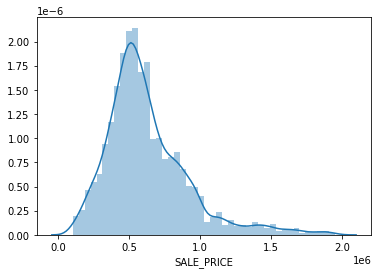

In [240]:
#exploratory graphs to get a general understanding of the data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.distplot(subset['SALE_PRICE'])
plt.show()

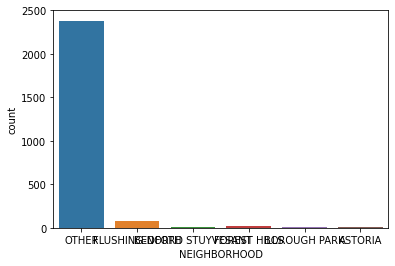

In [207]:
sns.countplot(train['NEIGHBORHOOD'])
plt.show()

In [208]:
#observations in Neigborhoods as proportions
train['NEIGHBORHOOD'].value_counts(normalize=True)

OTHER                 0.950140
FLUSHING-NORTH        0.030714
FOREST HILLS          0.006781
BOROUGH PARK          0.004787
ASTORIA               0.004388
BEDFORD STUYVESANT    0.003191
Name: NEIGHBORHOOD, dtype: float64

In [308]:
#cardinality referes to number of unique values in categorical data
#devide between high and low cardinality features first
#high cardinality  in this cases will correspod to unique valies in X_train.describe(exlude-'number')


target = 'SALE_PRICE'
high_cardinality = ['BOROUGH','BUILDING_CLASS_CATEGORY',	'TAX_CLASS_AT_PRESENT',	'BUILDING_CLASS_AT_PRESENT', 'ADDRESS',	'APARTMENT_NUMBER',	'LAND_SQUARE_FEET',	'BUILDING_CLASS_AT_TIME_OF_SALE',	'SALE_DATE']
features = train.columns.drop([target] + high_cardinality +['EASE-MENT'] )
#features will include categorical feature
#and low cardinality features like neighboorhood are included too
features

Index(['NEIGHBORHOOD', 'BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [309]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [310]:
#before encoding
print(X_train.shape, X_test.shape)

(2507, 10) (644, 10)


In [311]:
X_train

,NEIGHBORHOOD,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,OTHER,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
61,OTHER,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
78,OTHER,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1
108,OTHER,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1
111,OTHER,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1
...,...,...,...,...,...,...,...,...,...,...
18129,OTHER,4081,44,10306.0,1.0,0.0,1.0,921.0,1950.0,1
18130,OTHER,2373,201,10314.0,1.0,0.0,1.0,2128.0,1980.0,1
18132,OTHER,1132,42,10302.0,1.0,0.0,1.0,1807.0,2018.0,1
18134,OTHER,3395,37,10305.0,1.0,0.0,1.0,621.0,1930.0,1


In [93]:
#Import  OneHotEncoder from LIBRARY category_encoders
# estimator class  --- most things in scikit learn --- characterize by dot .fit() method
# Predictor = anything w/ .predict method
# transfor  = anythin .transform()
 
#One hot encoder is going to transform categorical variables into 0 and 1s.
#Each value will take on a new column

In [312]:
import category_encoders as ce 
encoder = ce.OneHotEncoder(use_cat_names=True)
#fit function its learning something from training data and apply it to test data
#looking for what the categorical variables are and then applying encoding
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [313]:

X_train

,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,1,0,0,0,0,0,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
61,1,0,0,0,0,0,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
78,1,0,0,0,0,0,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1
108,1,0,0,0,0,0,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1
111,1,0,0,0,0,0,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,1,0,0,0,0,0,4081,44,10306.0,1.0,0.0,1.0,921.0,1950.0,1
18130,1,0,0,0,0,0,2373,201,10314.0,1.0,0.0,1.0,2128.0,1980.0,1
18132,1,0,0,0,0,0,1132,42,10302.0,1.0,0.0,1.0,1807.0,2018.0,1
18134,1,0,0,0,0,0,3395,37,10305.0,1.0,0.0,1.0,621.0,1930.0,1


In [314]:
#columns that have 0 variance or have constant values
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_train)
constant_columns = [column for column in X_train.columns if column not in X_train.columns[constant_filter.get_support()]]
for column in constant_columns:
  print("Removed ", column)


Removed  TAX_CLASS_AT_TIME_OF_SALE


In [315]:
X_train = X_train.drop('TAX_CLASS_AT_TIME_OF_SALE',axis=1)
X_test = X_test.drop('TAX_CLASS_AT_TIME_OF_SALE',axis=1)

In [316]:
X_train.isnull().sum(),X_train.isnull().sum()

(NEIGHBORHOOD_OTHER                 0
 NEIGHBORHOOD_FLUSHING-NORTH        0
 NEIGHBORHOOD_BEDFORD STUYVESANT    0
 NEIGHBORHOOD_FOREST HILLS          0
 NEIGHBORHOOD_BOROUGH PARK          0
 NEIGHBORHOOD_ASTORIA               0
 BLOCK                              0
 LOT                                0
 ZIP_CODE                           0
 RESIDENTIAL_UNITS                  0
 COMMERCIAL_UNITS                   0
 TOTAL_UNITS                        0
 GROSS_SQUARE_FEET                  0
 YEAR_BUILT                         0
 dtype: int64, NEIGHBORHOOD_OTHER                 0
 NEIGHBORHOOD_FLUSHING-NORTH        0
 NEIGHBORHOOD_BEDFORD STUYVESANT    0
 NEIGHBORHOOD_FOREST HILLS          0
 NEIGHBORHOOD_BOROUGH PARK          0
 NEIGHBORHOOD_ASTORIA               0
 BLOCK                              0
 LOT                                0
 ZIP_CODE                           0
 RESIDENTIAL_UNITS                  0
 COMMERCIAL_UNITS                   0
 TOTAL_UNITS                        

In [317]:
#Feature selection w/ select k best is a class of unveriate feature selection
#Alot of features, Select K best is useful
from sklearn.feature_selection import SelectKBest

#instantiate our selector object
# Select top 5 features
selector = SelectKBest(k=5)


X_train_selected = selector.fit_transform(X_train, y_train)


In [303]:
X_test_selected = selector.transform(X_test)
#GET RUN TIME ERROR DEPENDING ON THE CATEGORICAL VARIABLE

In [304]:
X_train_selected.shape, X_test_selected.shape

((2507, 5), (644, 5))

In [305]:
#which features were selected?
#mask of true/false values selected
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]
print('Features selected:')
for  name in selected_names:
  print (name)

print ('Features excluded:')
for name in unselected_names:
  print (name)



Features selected:
BOROUGH_1
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_ASTORIA
GROSS_SQUARE_FEET
YEAR_BUILT
Features excluded:
BOROUGH_3
BOROUGH_4
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_BOROUGH PARK
BLOCK
LOT
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS


In [318]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
  print(f'{k} features')
  selector = SelectKBest(k=k)
  
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test,y_pred)
  print(f' Test Mean Absolute Error: ${mae:,.0f}\n')

#works in this sitation but get warning errors if I use the BOROUGH CATEGORY

1 features
 Test Mean Absolute Error: $212,078

2 features
 Test Mean Absolute Error: $209,538

3 features
 Test Mean Absolute Error: $182,129

4 features
 Test Mean Absolute Error: $181,934

5 features
 Test Mean Absolute Error: $178,257

6 features
 Test Mean Absolute Error: $178,665

7 features
 Test Mean Absolute Error: $173,682

8 features
 Test Mean Absolute Error: $174,245

9 features
 Test Mean Absolute Error: $174,245

10 features
 Test Mean Absolute Error: $174,036

11 features
 Test Mean Absolute Error: $174,238

12 features
 Test Mean Absolute Error: $161,796

13 features
 Test Mean Absolute Error: $162,122

14 features
 Test Mean Absolute Error: $162,122



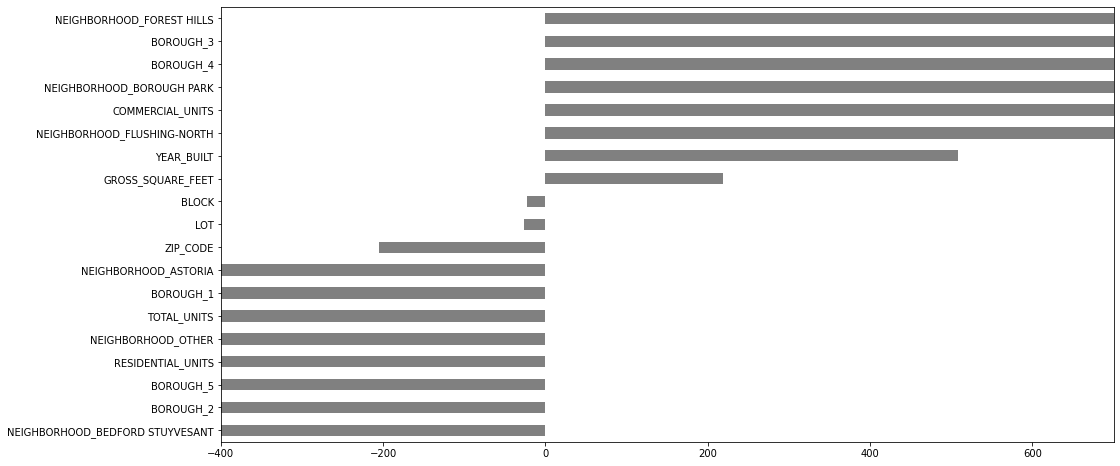

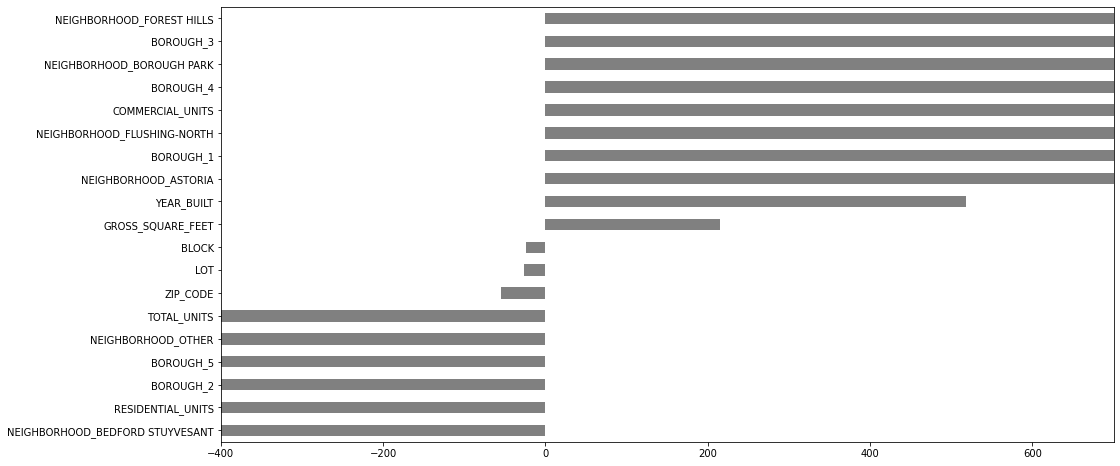

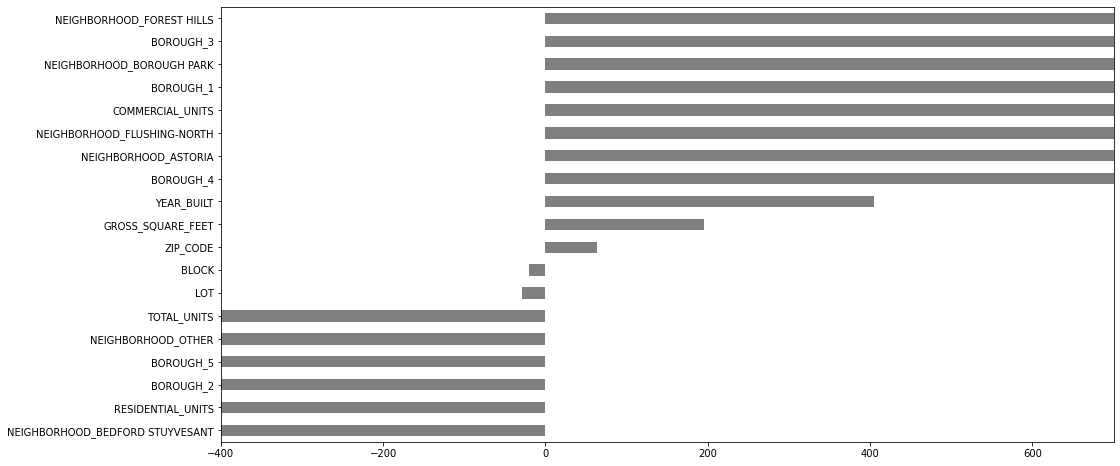

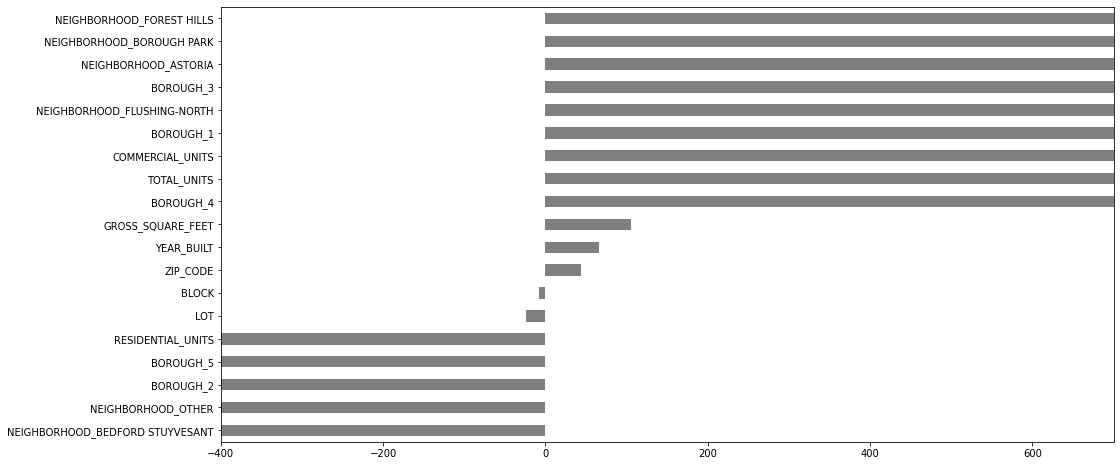

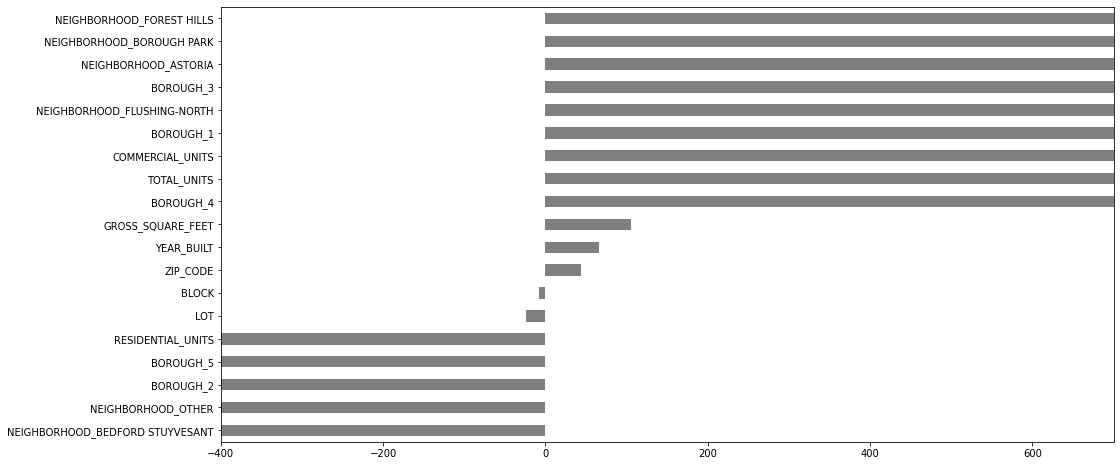

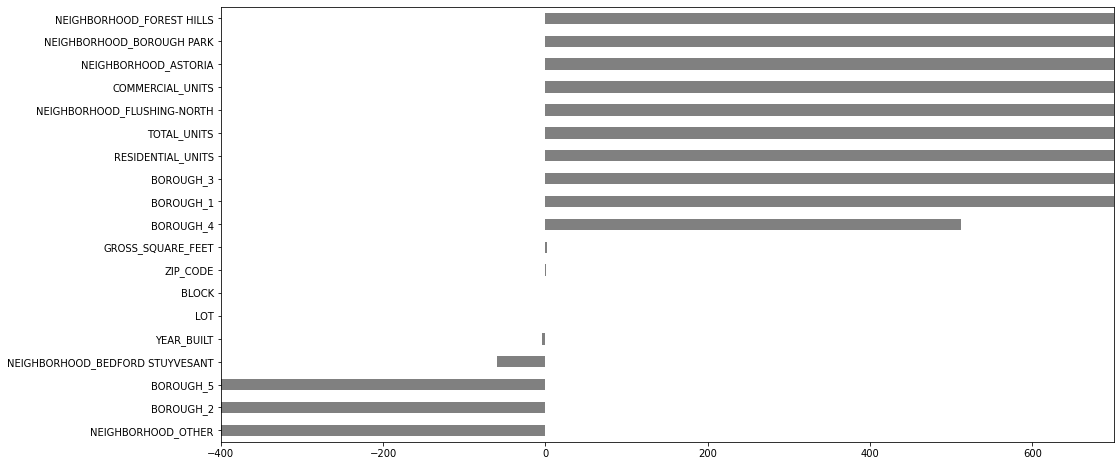

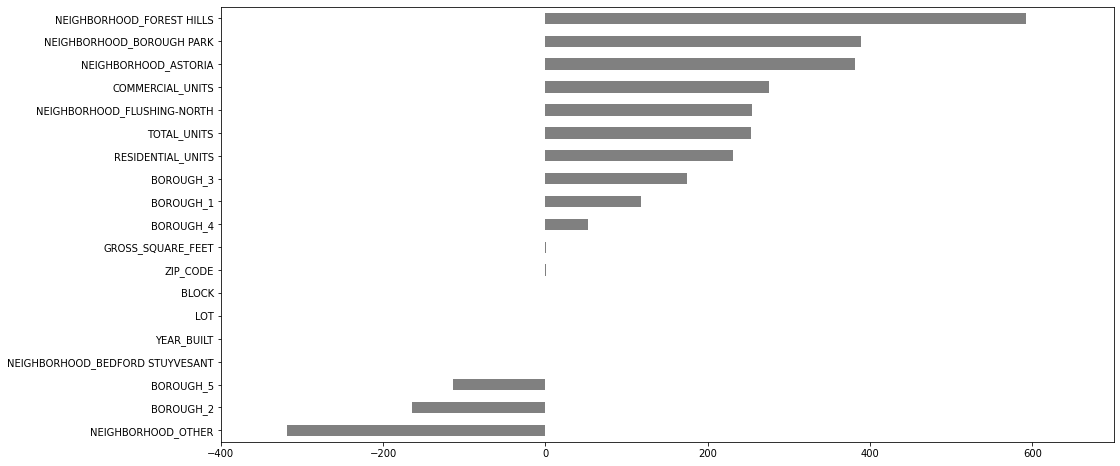

In [307]:
from IPython.display import display, HTML
from sklearn.linear_model import Ridge
for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    #include all features in our training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    #look for the plots that minimize the large coefficients
    #Don't want the extreme values
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,700)
    plt.show()